In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from category_encoders import OneHotEncoder

## Prepare data

### Import

In [2]:
def wrangle(filepath):
    df = pd.read_excel(filepath)
    
    #Drop leaky column
    df.drop(columns="BWT", inplace=True)
    
    #Rename columns
    df. columns =["Birth_weight", "Age", "Mother_weight", "Race", "Smoking_status",
                  "History_of_premature_labor", "History_of_Hypertension", "Presence_of_uterine_irritability", "Physician_visits"]
    
    #Rename values in categorical variables columns
    df["Race"] = df["Race"].map({1:"White", 2:"Black", 3:"Others"})
    df["Smoking_status"] = df["Smoking_status"].map({0:"No", 1:"Yes"})
    df["History_of_Hypertension"] = df["History_of_Hypertension"].map({0:"No", 1:"Yes"})
    df["Presence_of_uterine_irritability"] = df["Presence_of_uterine_irritability"].map({0:"No", 1:"Yes"})
    
    return df

In [3]:
df = wrangle("data/low_birth_weight.xls")
df.head()

,Birth_weight,Age,Mother_weight,Race,Smoking_status,History_of_premature_labor,History_of_Hypertension,Presence_of_uterine_irritability,Physician_visits
0,0,29,140,White,Yes,0,No,No,2
1,0,32,132,White,No,0,No,No,4
2,0,36,175,White,No,0,No,No,0
3,1,14,100,Others,No,0,No,No,2
4,0,25,130,White,No,0,No,No,2


### Explore

In [57]:
df["Mother_weight"].()

75

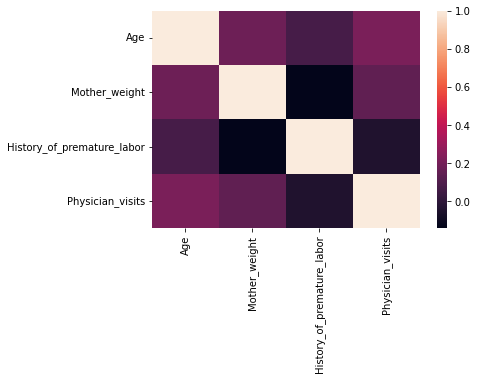

In [5]:
#Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="Birth_weight").corr()
#Plot heatmap
sns.heatmap(correlation);

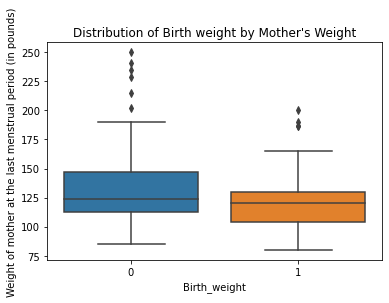

In [7]:
sns.boxplot(x="Birth_weight", y="Mother_weight", data=df)
# Label axes
plt.xlabel("Birth_weight")
plt.ylabel("Weight of mother at the last menstrual period (in pounds)")
plt.title("Distribution of Birth weight by Mother's Weight");

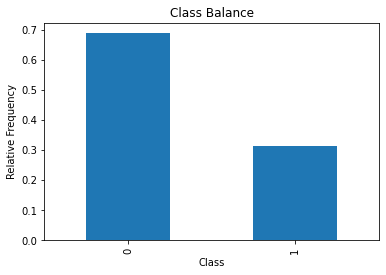

In [8]:
#Check the class balance
df["Birth_weight"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class Balance"
);

In [9]:
#Create two variables to store the normalized value counts for the two classes in df["Birth_weight"]
majority_class_prop, minority_class_prop = df["Birth_weight"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6878306878306878 0.31216931216931215


Are babies born to women of certain races more likely to suffer low birth weight?  I'll create a pivot table to find out

In [10]:
#Create Pivot table
race_pivot = pd.pivot_table(
    df, index="Race", values= "Birth_weight", aggfunc=np.mean
).sort_values(by="Birth_weight")
race_pivot

,Birth_weight
Race,
White,0.239583
Others,0.373134
Black,0.423077


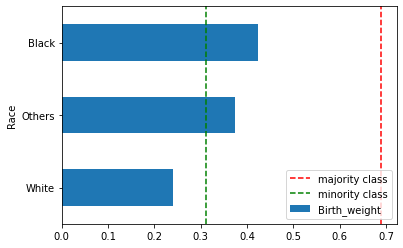

In [11]:
# Plot bar chart of `race_pivot`
race_pivot.plot(kind="barh")
plt.axvline(
    majority_class_prop, linestyle="--", color="red", label="majority class"
)
plt.axvline(
   minority_class_prop, linestyle="--", color="green", label="minority class"
)
plt.legend(loc="lower right");

In [12]:
# Check for high- and low-cardinality categorical features
df.select_dtypes("object").nunique()

Race                                3
Smoking_status                      2
History_of_Hypertension             2
Presence_of_uterine_irritability    2
dtype: int64

## Split

In [13]:
target="Birth_weight"
X = df.drop(columns=target)
y = df[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (151, 8)
y_train shape: (151,)
X_test shape: (38, 8)
y_test shape: (38,)


## Build Model

### Baseline

In [15]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.66


### Iterate

In [16]:
#Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)
#Fit model to training data
model.fit(X_train, y_train)

C:\Users\Virtues\miniconda3\envs\geo_ds\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Race', 'Smoking_status',
                                     'History_of_Hypertension',
                                     'Presence_of_uterine_irritability'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [17]:
check_is_fitted(model)

## Evaluate

In [18]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.74
Test Accuracy: 0.74


## Communicate

In [19]:
model.predict(X_train)[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [20]:
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.76469177 0.23530823]
 [0.91524365 0.08475635]
 [0.65677719 0.34322281]
 [0.83778596 0.16221404]
 [0.81830257 0.18169743]]


In [21]:
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

In [22]:
odds_ratios = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratios.head()

History_of_Hypertension_No             0.417609
Race_White                             0.536811
Presence_of_uterine_irritability_No    0.608152
Smoking_status_No                      0.673485
Age                                    0.968053
dtype: float64

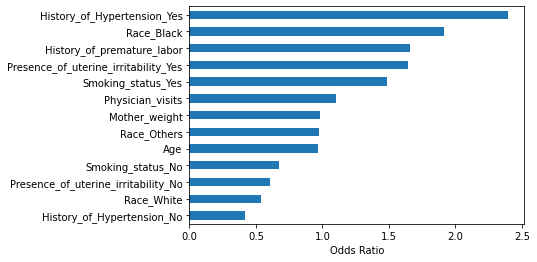

In [23]:
odds_ratios.plot(kind = "barh")
plt.xlabel("Odds Ratio");

In [25]:
X_train.head()

,Age,Mother_weight,Race,Smoking_status,History_of_premature_labor,History_of_Hypertension,Presence_of_uterine_irritability,Physician_visits
35,23,120,Others,No,0,No,No,0
98,35,170,White,No,1,No,No,1
104,25,125,Black,No,0,No,No,0
75,24,116,White,No,0,No,No,1
93,28,130,Others,No,0,No,No,0


In [53]:
def make_prediction(Age, Mother_weight, Race, Smoking_status, History_of_premature_labor, History_of_Hypertension, Presence_of_uterine_irritability,Physician_visits):
    data = {
        "Age": Age,  
        "Mother_weight": Mother_weight, 
        "Race": Race,
        "Smoking_status" : Smoking_status,                    
        "History_of_premature_labor":History_of_premature_labor,
        "History_of_Hypertension":History_of_Hypertension,
        "Presence_of_uterine_irritability": Presence_of_uterine_irritability,
        "Physician_visits": Physician_visits
    }
    df = pd.DataFrame(data, index=[0])
    predicted_value = {
        0:"Normal birth weight",
        1:"Low birth weight"
    }
    
    prediction = model.predict(df)
    
    my_dict = {
        0:"NBW",
        1:"LBW"
    }
    return f"The predicted outcome is: {np.vectorize(my_dict.get)(prediction[0])}"

In [54]:
make_prediction(23, 120, "White", "No", 1, "Yes", "Yes", 1)

'The predicted outcome is: LBW'